<a href="https://colab.research.google.com/github/LLealL/Xray-Covid-CNN/blob/main/C%C3%B3pia_de_Projeto_Final_Modularizado_Lucas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação de Bibliotecas**

In [ ]:
from PIL import Image
import csv
from os import listdir
from os.path import isdir, isfile
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model



#Configuração do Google Drive

In [ ]:
# Habilita o uso do Google Drive para acessar os arquivos
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/Shared drives/projeto_rn/projeto'

Mounted at /content/drive


#PreProcess

In [ ]:
def getImagens(lista,imagens):
  imagem_path = "//content//drive//Shared drives//projeto_rn//projeto//imagens//dataset Treino//dataset Treino//"
  for imagem in lista:
    img = Image.open("//content//drive//Shared drives//projeto_rn//projeto//imagens//dataset Treino//dataset Treino//" + imagem)
    img = img.convert('RGB')
    img = img.resize((250,250))
    imagens.append(np.asarray(img)/255)
  imagens = np.array(imagens)
  return imagens

def PreProcess():
  mycsv = '/content/drive/Shared drives/projeto_rn/projeto/labels_projeto_rna_csv.csv'
  lista_de_imagens = []
  lista_de_classes = []


  print("Abrindo arquivo CSV: ", mycsv)
  with open(mycsv,'r', encoding='UTF-8') as arquivo_csv:
    arquivo_de_labels = csv.reader(arquivo_csv,delimiter=';')
    for registro in arquivo_de_labels:
      lista_de_imagens.append(registro[0])
      lista_de_classes.append(registro[4])
    lista_de_imagens.pop(0)
    lista_de_classes.pop(0)
  print("Lista de imagens e classes extraída!")
  
  
  imagem_path = "//content//drive//Shared drives//projeto_rn//projeto//imagens//dataset Treino//dataset Treino//"
  labels = list()
  imagens = list()
  print("Carregando Imagens...")
  imagens = getImagens(lista_de_imagens,imagens)

  imagens = np.array(imagens)
  print("Binarizando Labels...")
  labels = np.array(lista_de_classes)
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = np.asarray(labels)

  print("Separando conjunto de teste e treino...")
  (treinoImagem, valImagem, treinoLabel, valLabel) = train_test_split(imagens, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=labels,                                                                     
                                                                      random_state=43)
  print("PreProcessamento finalizado")
  return treinoImagem,valImagem,treinoLabel,valLabel


# Definição da Arquitetura da Rede Neural 


In [ ]:

def compile_model():
  model = models.Sequential()
  model.add(Conv2D(32, (25,25),input_shape= (250,250,3), padding='same', activation='relu'))
  model.add(Conv2D(32, (25,25), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(layers.BatchNormalization())
  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(32))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(3))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
  print("Modelo Compilado...")
  return model


#Data_Augment e Train_Model

In [ ]:

def data_augment(batch,trainX,trainY):
  train_datagen = ImageDataGenerator(
      rotation_range=20,
      zoom_range=0.2)

  train_datagen.fit(trainX)

  data_aug = train_datagen.flow(trainX, trainY, batch_size=batch)
  return data_aug

def create_callbacks(alpha):
  filepath="transferlearning_weights.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

  callbacks = [checkpoint, lr_reduce]
  return callbacks

def train_Model(trainX,trainY,testX,testY,model):
  batch_size   = 16
  random_state = 42
  alpha        = 1e-5
  epoch        = 60

  print("Criando Array de callbacks")
  callbacks = create_callbacks(alpha)
  print("Criando data augmentator")
  data_aug = data_augment(batch_size,np.array(trainX),np.array(trainY))
  print("Iniciando treino do Modelo...")
  history = model.fit(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size, # parte inteira da divisão
                              validation_data=(np.array(testX), np.array(testY)),
                              validation_steps=len(testX) // batch_size,# parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch)
  return history, model


#EXECUTE_MODEL e saves/loads

In [ ]:
def ask():
  yes = {'sim','s', 'si', ''}
  no = {'nao','n'}

  choice = input().lower()
  if choice in yes:
    return True
  elif choice in no:
    return False
  else:
    sys.stdout.write("Responda com 's' or 'n'")

def saveModel(model):
  model.save("modeloJJLM.h5") # modelo de João, Jone,Lucas e Messias kkk
  print("Modelo salvo!")

def loadModel():
  model = load_model('modeloJJLM.h5')
  return model

# Arquivo CSV da base
def execute_Model():  
 
  if isfile('modeloJJLM.h5'):
    print("Deseja Carregar modelo salvo? s/n")
    if ask():
      model = loadModel()
      trainX,testX,trainY,testY = PreProcess()
      evaluate_model(testX,testY,model)
    else:
      trainX,testX,trainY,testY = PreProcess()

      modelo = compile_model()
      print("Iniciando Modelo...")
      history,model = train_Model(trainX,trainY,testX,testY,modelo)
      plotGraficos(history)
      evaluate_model(testX,testY,model)

      print("Deseja Salvar modelo? s/n")
      if ask():
        saveModel(model)
  else:
    trainX,testX,trainY,testY = PreProcess()


    modelo = compile_model()
    print("Iniciando Modelo...")
    history,model = train_Model(trainX,trainY,testX,testY,modelo)
    plotGraficos(history)
    evaluate_model(testX,testY,model)

    print("Deseja Salvar modelo? s/n")
    if ask():
      saveModel(model)


#EVALUATE MODEL e PREDICT

In [ ]:

def predict(imgPath,model):
    img = Image.open(imgPath)
    img = img.convert('RGB')
    img = img.resize((250,250))
    img = np.expand_dims(img, axis=0)
    img = np.asarray(img)/255
    pred = model.predict(img)
    pred = np.argmax(pred,axis = 1) 
    if pred == 0:
      print("COVID-19")
    if pred == 1:
      print("PNEUMONIA")
    if pred == 2:
      print("SAUDAVEL")

def plotGraficos(history):
  print("plotando gráficos...")
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


def evaluate_model(testX,testY,model):

  print("Testando Modelo")
  pred = model.predict(testX)
  pred = np.argmax(pred,axis = 1) 
  y_true = np.argmax(testY,axis = 1)

  print("Plotando matriz de confusão")
  cm = confusion_matrix(y_true, pred)
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1]+ cm[0,2])
  specificity = (cm[1, 1]+cm[2,2]) / (cm[1, 0] + cm[1, 1] + cm[1,2]+cm[2,0]+cm[2,1]+cm[2,2])

  print("0-covid19 \n1-Pneumonia \n2-Saudavel")
  print("Acurácia: {:.4f}".format(acc))
  print("Sensitividade: {:.4f}".format(sensitivity))
  print("Especificidade: {:.4f}".format(specificity))

  fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
  plt.show()



#MAIN



Abrindo arquivo CSV:  /content/drive/Shared drives/projeto_rn/projeto/labels_projeto_rna_csv.csv
Lista de imagens e classes extraída!
Carregando Imagens...
Binarizando Labels...
Separando conjunto de teste e treino...
PreProcessamento finalizado
Modelo Compilado...
Iniciando Modelo...
Criando Array de callbacks
Criando data augmentator
Iniciando treino do Modelo...
Epoch 1/60
10/10 [==============================] - ETA: 0s - loss: 1.0729 - acc: 0.5375
Epoch 00001: val_acc improved from -inf to 0.20000, saving model to transferlearning_weights.hdf5
10/10 [==============================] - 9s 857ms/step - loss: 1.0729 - acc: 0.5375 - val_loss: 22.1625 - val_acc: 0.2000
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 1.0958 - acc: 0.6500
Epoch 00002: val_acc did not improve from 0.20000
10/10 [==============================] - 7s 673ms/step - loss: 1.0958 - acc: 0.6500 - val_loss: 15.5373 - val_acc: 0.2000
Epoch 3/60
10/10 [==============================] - ETA: 0s - 

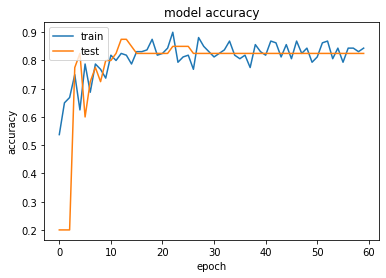

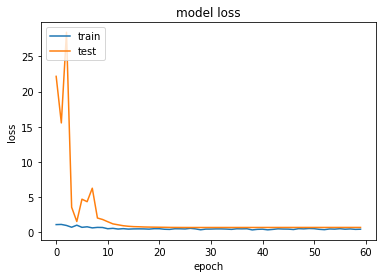

Testando Modelo
Plotando matriz de confusão
0-covid19 
1-Pneumonia 
2-Saudavel
Acurácia: 0.8250
Sensitividade: 1.0000
Especificidade: 0.7500


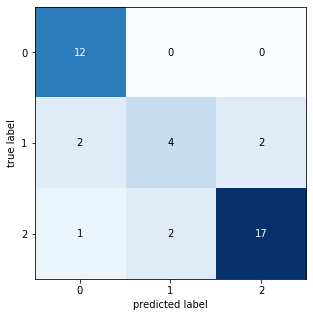

Deseja Salvar modelo? s/n


In [ ]:
execute_Model()